# House price analysis - version 4 
My notebook for [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels?userId=1075113) competition

## Credit: Many thanks to:
- Pedro Marcelino [Comprehensive data exploration with Python](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)

- Sergei Neviadomski [How to get to TOP 25% with Simple Model (sklearn)](https://www.kaggle.com/neviadomski/how-to-get-to-top-25-with-simple-model-sklearn)

- juliencsA [study on Regression applied to the Ames dataset](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset)
- BradenFitz-Gerald [RandomForestRegressor](https://www.kaggle.com/dfitzgerald3/randomforestregressor)
- Tanner Carbonati [Detailed Data Analysis & Ensemble Modeling] (https://www.kaggle.com/tannercarbonati/detailed-data-analysis-ensemble-modeling/comments/notebook)

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve, validation_curve, KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel
from xgboost.sklearn import XGBRegressor
from math import sqrt
from scipy import stats
import datetime
import sys
from inspect import getsourcefile
import os.path
import re
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# Input data files are available in the DATA_DIR directory.
DATA_DIR = "data-temp"

# Load and combine data

In [90]:
# Load data. Download from:https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
train_data = pd.read_csv(DATA_DIR + "/train.csv")
eval_data =  pd.read_csv(DATA_DIR + "/test.csv")

In [91]:
# Combine data
# Initial features
o_features = eval_data.columns.values
label = 'SalePrice'
# Store eval_id
eval_data_id = eval_data['Id']
#Seperate input and label from train_data
input_data = train_data[o_features]
target = train_data[label]
#input_data.head(5)
#Combine train + eval data
combine_data = pd.concat([input_data, eval_data], keys=['train','eval'])
data = combine_data
combine_data.head(5)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
train 0   1          60       RL         65.0     8450   Pave   NaN      Reg   
      1   2          20       RL         80.0     9600   Pave   NaN      Reg   
      2   3          60       RL         68.0    11250   Pave   NaN      IR1   
      3   4          70       RL         60.0     9550   Pave   NaN      IR1   
      4   5          60       RL         84.0    14260   Pave   NaN      IR1   

        LandContour Utilities      ...       ScreenPorch PoolArea PoolQC  \
train 0         Lvl    AllPub      ...                 0        0    NaN   
      1         Lvl    AllPub      ...                 0        0    NaN   
      2         Lvl    AllPub      ...                 0        0    NaN   
      3         Lvl    AllPub      ...                 0        0    NaN   
      4         Lvl    AllPub      ...                 0        0    NaN   

        Fence MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  
train 0   NaN         NaN       0      2    2008        WD         Normal  
      1   NaN         NaN       0      5    2007        WD         Normal  
      2   NaN         NaN       0      9    2008        WD         Normal  
      3   NaN         NaN       0      2    2006        WD        Abnorml  
      4   NaN         NaN       0     12    2008        WD         Normal  

[5 rows x 80 columns]

# Fill NaN values

### Check NaN columns

In [92]:
#data[data['GarageArea']>0]['GarageArea']

In [93]:
def check_null_data():
    #Get high percent of NaN data
    null_data = combine_data.isnull()
    total = null_data.sum().sort_values(ascending=False)
    percent = (null_data.sum()/null_data.count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    high_percent_miss_data = missing_data[missing_data['Percent']>0]
    #print(missing_data)
    print(high_percent_miss_data)
    miss_data_cols = high_percent_miss_data.index.values
    return miss_data_cols

In [94]:
miss_data_cols = check_null_data()
print(miss_data_cols)

              Total   Percent
PoolQC         2909  0.996574
MiscFeature    2814  0.964029
Alley          2721  0.932169
Fence          2348  0.804385
FireplaceQu    1420  0.486468
LotFrontage     486  0.166495
GarageCond      159  0.054471
GarageQual      159  0.054471
GarageYrBlt     159  0.054471
GarageFinish    159  0.054471
GarageType      157  0.053786
BsmtCond         82  0.028092
BsmtExposure     82  0.028092
BsmtQual         81  0.027749
BsmtFinType2     80  0.027407
BsmtFinType1     79  0.027064
MasVnrType       24  0.008222
MasVnrArea       23  0.007879
MSZoning          4  0.001370
BsmtHalfBath      2  0.000685
Utilities         2  0.000685
Functional        2  0.000685
BsmtFullBath      2  0.000685
BsmtFinSF1        1  0.000343
Exterior1st       1  0.000343
Exterior2nd       1  0.000343
BsmtFinSF2        1  0.000343
BsmtUnfSF         1  0.000343
TotalBsmtSF       1  0.000343
SaleType          1  0.000343
Electrical        1  0.000343
KitchenQual       1  0.000343
GarageArea

### PoolQC

train  0    NaN
       1    NaN
       2    NaN
       3    NaN
       4    NaN
Name: PoolQC, dtype: object


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2934f70828>], dtype=object)

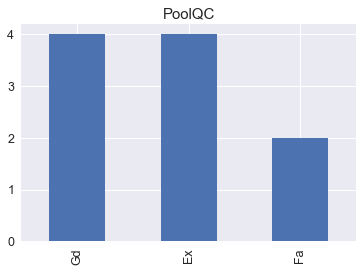

In [95]:
# PoolQC
col = 'PoolQC'
print(data[col].head(5))
data[col].value_counts().plot(kind='bar', subplots=True)

In [96]:
# Check NaN PoolQC with PoolArea
combine_data[['Id', col, 'PoolArea']][(combine_data[col].isnull()) & (combine_data['PoolArea']>0)]

Id PoolQC  PoolArea
eval 960   2421    NaN       368
     1043  2504    NaN       444
     1139  2600    NaN       561

In [97]:
#Check AVG PoolArea by PoolQC
combine_data[[col, 'PoolArea']].groupby(col).mean()

,PoolArea
PoolQC,
Ex,359.75
Fa,583.50
Gd,648.50


In [98]:
# Filling special value of PoolQC
data.loc[data['Id'] == 2421, col] = 'Ex'
data.loc[data['Id'] == 2504, col] = 'Ex'
data.loc[data['Id'] == 2600, col] = 'Fa'
data[col].fillna('None', inplace=True)

- GarageType: Garage location
- GarageYrBlt: Year garage was built
- GarageFinish: Interior finish of the garage
- GarageCars: Size of garage in car capacity
- GarageArea: Size of garage in square feet
- GarageQual: Garage quality
- GarageCond: Garage condition

### GarageYrBlt

In [99]:
# Check GarageYrBlt & YearBuilt
col = 'GarageYrBlt'
print("Number of same YearBuild=", col, ":", len(data[data[col] == data['YearBuilt']]))

Number of same YearBuild= GarageYrBlt : 2216


In [100]:
# Update GarageYrBlt = YearBuilt
data.loc[data[col].isnull(), col] = data.loc[data[col].isnull(),'YearBuilt']
data[['Id', col,'YearBuilt']].loc[data['Id'] == 40]

,,Id,GarageYrBlt,YearBuilt
train,39,40,1955.0,1955


### Garage columns

In [101]:
cols = ['GarageArea', 'GarageCars', 'GarageQual', 'GarageFinish', 'GarageCond', 'GarageType']
for col in cols:
    if data[col].dtype == 'object':
        data.loc[data[col].isnull(), col] = 'None'
    else:
        data.loc[data[col].isnull(), col] = 0
data[cols].head(10)        

GarageArea  GarageCars GarageQual GarageFinish GarageCond GarageType
train 0       548.0         2.0         TA          RFn         TA     Attchd
      1       460.0         2.0         TA          RFn         TA     Attchd
      2       608.0         2.0         TA          RFn         TA     Attchd
      3       642.0         3.0         TA          Unf         TA     Detchd
      4       836.0         3.0         TA          RFn         TA     Attchd
      5       480.0         2.0         TA          Unf         TA     Attchd
      6       636.0         2.0         TA          RFn         TA     Attchd
      7       484.0         2.0         TA          RFn         TA     Attchd
      8       468.0         2.0         Fa          Unf         TA     Detchd
      9       205.0         1.0         Gd          RFn         TA     Attchd

### KitchenQual: Kitchen quality

Number of null value for: KitchenQual : 1


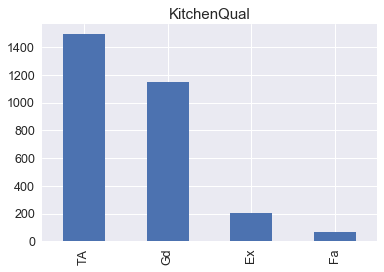

In [102]:
col = 'KitchenQual'
null_data = data[data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
data[col].value_counts().plot(kind='bar', subplots=True)
data.loc[data[col].isnull(), col] = 'TA'

### Electrical: Electrical system

Number of null value for: Electrical : 1


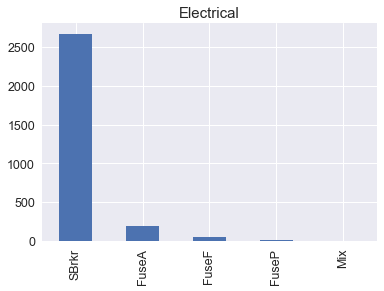

In [103]:
col = 'Electrical'
null_data = data[data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
data[col].value_counts().plot(kind='bar', subplots=True)
data.loc[data[col].isnull(), col] = 'SBrkr'

- BsmtQual: Height of the basement
- BsmtCond: General condition of the basement
- BsmtExposure: Walkout or garden level basement walls
- BsmtFinType1: Quality of basement finished area
- BsmtFinSF1: Type 1 finished square feet
- BsmtFinType2: Quality of second finished area (if present)
- BsmtFinSF2: Type 2 finished square feet
- BsmtUnfSF: Unfinished square feet of basement area
- TotalBsmtSF: Total square feet of basement area
- BsmtFullBath: Basement full bathrooms
- BsmtHalfBath: Basement half bathrooms

In [104]:
# Select cols with name match *Bsmt*
all_cols = data.columns.values
r = re.compile("Bsmt")
cols = list(filter(r.search, all_cols))
cols

['BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath']

In [105]:
# Check null for *Bsmt*
null_data = data[cols].isnull()
total = null_data.sum().sort_values(ascending=False)
total[total>0]

BsmtExposure    82
BsmtCond        82
BsmtQual        81
BsmtFinType2    80
BsmtFinType1    79
BsmtHalfBath     2
BsmtFullBath     2
TotalBsmtSF      1
BsmtUnfSF        1
BsmtFinSF2       1
BsmtFinSF1       1
dtype: int64

Number of null value for: BsmtExposure : 82


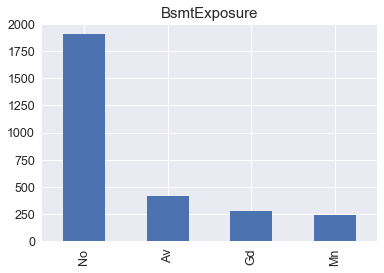

In [106]:
# BsmtExposure
col = 'BsmtExposure'
null_data = data[data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
data[col].value_counts().plot(kind='bar', subplots=True)
data.loc[data[col].isnull(), col] = 'No'

In [107]:
# Other Bsmt cols
for col in cols:
    print(col, ":", data[col].dtype)
    if data[col].dtype == 'object':
        data.loc[data[col].isnull(), col] = 'None'
    else:
        data.loc[data[col].isnull(), col] = 0

BsmtQual : object
BsmtCond : object
BsmtExposure : object
BsmtFinType1 : object
BsmtFinSF1 : float64
BsmtFinType2 : object
BsmtFinSF2 : float64
BsmtUnfSF : float64
TotalBsmtSF : float64
BsmtFullBath : float64
BsmtHalfBath : float64


- Exterior1st: Exterior covering on house
- Exterior2nd: Exterior covering on house (if more than one material)

Number of null value for: Exterior1st : 1


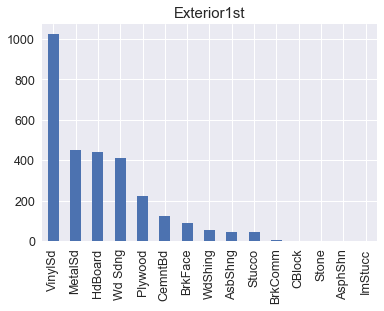

In [108]:
# Check for null Exterior1st
col ='Exterior1st'
null_data = data[data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
data[col].value_counts().plot(kind='bar', subplots=True)
data.loc[data[col].isnull(), col] = 'None'

Number of null value for: Exterior2nd : 1


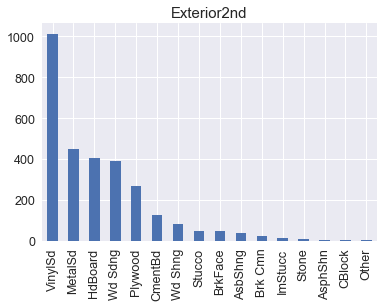

In [109]:
# Check for null Exterior2nd
col ='Exterior2nd'
null_data = data[data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
data[col].value_counts().plot(kind='bar', subplots=True)
data.loc[data[col].isnull(), col] = 'None'

### SaleType: Type of sale

In [110]:
# Check for null SaleType
col ='SaleType'
null_data = data[data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
print(data.loc[data[col].isnull(), [col, 'SaleCondition']])
data.loc[data[col].isnull(), col] = 'WD'
#data.loc[data[col].isnull(), col] = 'None'

Number of null value for: SaleType : 1
          SaleType SaleCondition
eval 1029      NaN        Normal


In [111]:
# Use crosstab to see frequency between SaleType and SaleCondition
pd.crosstab(data['SaleCondition'], data[col])

SaleType,COD,CWD,Con,ConLD,ConLI,ConLw,New,Oth,WD
SaleCondition,,,,,,,,,
Abnorml,46,1,0,3,2,0,0,5,133
AdjLand,0,0,0,0,0,0,0,0,12
Alloca,0,0,0,0,0,0,0,0,24
Family,2,1,0,1,2,1,0,1,38
Normal,39,10,4,21,5,7,0,1,2315
Partial,0,0,1,1,0,0,239,0,4


### Functional: Home functionality rating

Number of null value for: Functional : 2


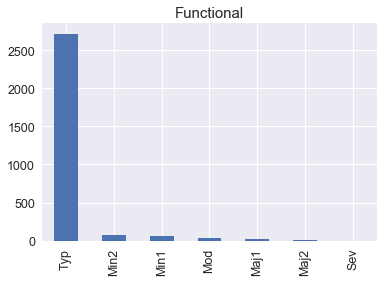

In [112]:
# Check for null Functional
col ='Functional'
null_data = data[data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
data[col].value_counts().plot(kind='bar', subplots=True)
data.loc[data[col].isnull(), col] = 'Typ'

### Utilities: Type of utilities available

Number of null value for: Utilities : 2


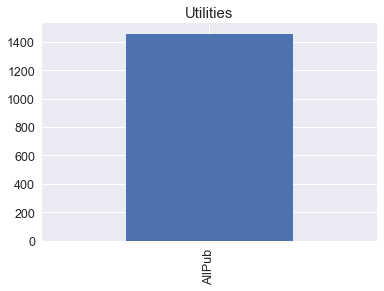

In [113]:
# Check for null Functional
col ='Utilities'
#null_data = data[data[col].isnull()]
#null_data = train_data[train_data[col].isnull()]
null_data = eval_data[eval_data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
eval_data[col].value_counts().plot(kind='bar', subplots=True)
data.loc[data[col].isnull(), col] = 'AllPub'

### MSZoning: The general zoning classification

Number of null value for: MSZoning : 4


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2934ea5c18>], dtype=object)

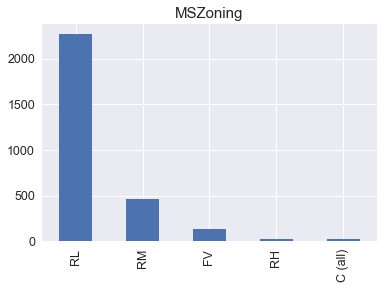

In [114]:
# Check for null MSZoning
col ='MSZoning'
null_data = data[data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
data[col].value_counts().plot(kind='bar', subplots=True)

In [115]:
# Check relationship between MSZoning and MSSubClass for NaN values
data.loc[data[col].isnull(), ['Id', col, 'MSSubClass']]

Id MSZoning  MSSubClass
eval 455   1916      NaN          30
     756   2217      NaN          20
     790   2251      NaN          70
     1444  2905      NaN          20

In [116]:
# Use crosstab to see frequency between MSZoning and MSSubClass
pd.crosstab(data[col], data['MSSubClass'])

MSSubClass,20,30,40,45,50,60,70,75,80,85,90,120,150,160,180,190
MSZoning,,,,,,,,,,,,,,,,
C (all),3,8,0,0,7,0,4,0,0,0,0,0,0,0,0,3
FV,34,0,0,0,0,43,0,0,0,0,0,19,0,43,0,0
RH,4,2,0,1,2,0,3,0,0,0,4,6,0,0,0,4
RL,1016,61,4,6,159,529,57,9,115,47,92,117,1,21,0,31
RM,20,67,2,11,119,3,63,14,3,1,13,40,0,64,17,23


In [117]:
# Fill NaN for MSZoning
data.loc[(data['Id'] == 2217) | (data['Id'] == 2905) , col] = 'RL'
data.loc[data['Id'] == 1916, col] = 'RM'
data.loc[data['Id'] == 2251, col] = 'RM'

- MasVnrType: Masonry veneer type
- MasVnrArea: Masonry veneer area in square feet

In [118]:
# Check for null MasVnrType
col = 'MasVnrType'
null_data = data[data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
data.loc[data[col].isnull(), col] = 'None'

Number of null value for: MasVnrType : 24


In [119]:
# Check for null MasVnrType
col = 'MasVnrArea'
null_data = data[data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
data.loc[data[col].isnull(), col] = 0

Number of null value for: MasVnrArea : 23


### LotFrontage: Linear feet of street connected to property

In [120]:
# Check for null LotFrontage
col = 'LotFrontage'
null_data = data[data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
data[col].fillna(data[col].mean(), inplace=True)

Number of null value for: LotFrontage : 486


- Fence: Fence quality
- MiscFeature

In [121]:
col = 'Fence'
data[col].fillna('None', inplace=True)

In [122]:
col = 'MiscFeature'
data[col].fillna('None', inplace=True)

- Fireplaces: Number of fireplaces
- FireplaceQu: Fireplace quality

In [123]:
col = 'FireplaceQu'
null_data = data[data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
# Check relationship between FireplaceQu and Fireplaces for NaN values
data.loc[data[col].isnull(), ['Id', col, 'Fireplaces']][:5]
data[col].fillna('None', inplace=True)

Number of null value for: FireplaceQu : 1420


### Alley: Type of alley access

In [124]:
col = 'Alley'
null_data = data[data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
data[col].fillna('None', inplace=True)

Number of null value for: Alley : 2721


In [125]:
## Check if any missing value remains

In [126]:
miss_data_cols = check_null_data()
print(miss_data_cols)

Empty DataFrame
Columns: [Total, Percent]
Index: []
[]


# Transform object data

In [127]:
object_data = combine_data.select_dtypes(include=['object'])
object_cols = object_data.columns.values
object_data.head(10)

MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
train 0       RL   Pave  None      Reg         Lvl    AllPub    Inside   
      1       RL   Pave  None      Reg         Lvl    AllPub       FR2   
      2       RL   Pave  None      IR1         Lvl    AllPub    Inside   
      3       RL   Pave  None      IR1         Lvl    AllPub    Corner   
      4       RL   Pave  None      IR1         Lvl    AllPub       FR2   
      5       RL   Pave  None      IR1         Lvl    AllPub    Inside   
      6       RL   Pave  None      Reg         Lvl    AllPub    Inside   
      7       RL   Pave  None      IR1         Lvl    AllPub    Corner   
      8       RM   Pave  None      Reg         Lvl    AllPub    Inside   
      9       RL   Pave  None      Reg         Lvl    AllPub    Corner   

        LandSlope Neighborhood Condition1      ...      GarageType  \
train 0       Gtl      CollgCr       Norm      ...          Attchd   
      1       Gtl      Veenker      Feedr      ...          Attchd   
      2       Gtl      CollgCr       Norm      ...          Attchd   
      3       Gtl      Crawfor       Norm      ...          Detchd   
      4       Gtl      NoRidge       Norm      ...          Attchd   
      5       Gtl      Mitchel       Norm      ...          Attchd   
      6       Gtl      Somerst       Norm      ...          Attchd   
      7       Gtl       NWAmes       PosN      ...          Attchd   
      8       Gtl      OldTown     Artery      ...          Detchd   
      9       Gtl      BrkSide     Artery      ...          Attchd   

        GarageFinish GarageQual GarageCond PavedDrive PoolQC  Fence  \
train 0          RFn         TA         TA          Y   None   None   
      1          RFn         TA         TA          Y   None   None   
      2          RFn         TA         TA          Y   None   None   
      3          Unf         TA         TA          Y   None   None   
      4          RFn         TA         TA          Y   None   None   
      5          Unf         TA         TA          Y   None  MnPrv   
      6          RFn         TA         TA          Y   None   None   
      7          RFn         TA         TA          Y   None   None   
      8          Unf         Fa         TA          Y   None   None   
      9          RFn         Gd         TA          Y   None   None   

        MiscFeature SaleType SaleCondition  
train 0        None       WD        Normal  
      1        None       WD        Normal  
      2        None       WD        Normal  
      3        None       WD       Abnorml  
      4        None       WD        Normal  
      5        Shed       WD        Normal  
      6        None       WD        Normal  
      7        Shed       WD        Normal  
      8        None       WD       Abnorml  
      9        None       WD        Normal  

[10 rows x 43 columns]

### Tranform category data based on mean of SalePrice

In [128]:
col = 'BsmtExposure'
#data[[col, label]].groupby(label).mean()
data_st = train_data[[col, label]].groupby(col,as_index=False).mean().sort_values(label).reset_index()
data_st[:5]

,index,BsmtExposure,SalePrice
0,3,No,165652.295908
1,2,Mn,192789.657895
2,0,Av,206643.420814
3,1,Gd,257689.805970


In [129]:
data_sr = pd.Series(data_st.index.values, index=data_st[col])
data_dict = data_sr.to_dict()
data_dict

{'Av': 2, 'Gd': 3, 'Mn': 1, 'No': 0}

In [130]:
object_data = data.select_dtypes(include=['object'])
object_features = object_data.columns.values
for col in object_features:
            # get numeric value of col based on mean of label
            data_st = train_data[[col, label]].groupby(col, as_index=False).mean()
            data_sr = pd.Series(data_st.index.values, index=data_st[col])
            data_dict = data_sr.to_dict()
            data_tf = data[col].map(data_dict)
            data[col].update(data_tf)
            # Update None = 0
            data.loc[data[col] == 'None', col] = 0
        

In [131]:
data[object_features][:20]

MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
train 0         3      1     0        3           3         0         4   
      1         3      1     0        3           3         0         2   
      2         3      1     0        0           3         0         4   
      3         3      1     0        0           3         0         0   
      4         3      1     0        0           3         0         2   
      5         3      1     0        0           3         0         4   
      6         3      1     0        3           3         0         4   
      7         3      1     0        0           3         0         0   
      8         4      1     0        3           3         0         4   
      9         3      1     0        3           3         0         0   
      10        3      1     0        3           3         0         4   
      11        3      1     0        0           3         0         4   
      12        3      1     0        1           3         0         4   
      13        3      1     0        0           3         0         4   
      14        3      1     0        0           3         0         0   
      15        4      1     0        3           3         0         0   
      16        3      1     0        0           3         0         1   
      17        3      1     0        3           3         0         4   
      18        3      1     0        3           3         0         4   
      19        3      1     0        3           3         0         4   

         LandSlope Neighborhood Condition1      ...      GarageType  \
train 0          0            5          2      ...               1   
      1          0           24          1      ...               1   
      2          0            5          2      ...               1   
      3          0            6          2      ...               5   
      4          0           15          2      ...               1   
      5          0           11          2      ...               1   
      6          0           21          2      ...               1   
      7          0           14          4      ...               1   
      8          0           17          0      ...               5   
      9          0            3          0      ...               1   
      10         0           19          2      ...               5   
      11         0           16          2      ...               3   
      12         0           19          2      ...               5   
      13         0            5          2      ...               1   
      14         0           12          2      ...               1   
      15         0            3          2      ...               5   
      16         0           12          2      ...               1   
      17         0           19          2      ...               4   
      18         0           20          5      ...               5   
      19         0           12          2      ...               1   

         GarageFinish GarageQual GarageCond PavedDrive PoolQC Fence  \
train 0             1          4          4          2      0     0   
      1             1          4          4          2      0     0   
      2             1          4          4          2      0     0   
      3             2          4          4          2      0     0   
      4             1          4          4          2      0     0   
      5             2          4          4          2      0     2   
      6             1          4          4          2      0     0   
      7             1          4          4          2      0     0   
      8             2          1          4          2      0     0   
      9             1          2          4          2      0     0   
      10            2          4          4          2      0     0   
      11            0          4          4          2      0     0   
      12          

### Transform numerical data

In [132]:
numeric_data = data.select_dtypes(include=[np.number])
std_scale = StandardScaler().fit_transform(numeric_data.values)
numeric_data_scale = pd.DataFrame(std_scale, index=numeric_data.index, columns=numeric_data.columns)
#numeric_data_scale[:20]
data_scale = data.copy()
data.update(numeric_data_scale)
data[:20]

Id  MSSubClass MSZoning  LotFrontage   LotArea Street Alley  \
train 0  -1.731458    0.067331        3    -0.202068 -0.217879      1     0   
      1  -1.730271   -0.873616        3     0.501870 -0.072044      1     0   
      2  -1.729084    0.067331        3    -0.061280  0.137197      1     0   
      3  -1.727897    0.302568        3    -0.436714 -0.078385      1     0   
      4  -1.726711    0.067331        3     0.689587  0.518903      1     0   
      5  -1.725524   -0.167905        3     0.736516  0.500515      1     0   
      6  -1.724337   -0.873616        3     0.267224 -0.010667      1     0   
      7  -1.723150    0.067331        3     0.000000  0.027123      1     0   
      8  -1.721964   -0.167905        4    -0.859076 -0.513352      1     0   
      9  -1.720777    3.125411        3    -0.906006 -0.348496      1     0   
      10 -1.719590   -0.873616        3     0.032578  0.130856      1     0   
      11 -1.718403    0.067331        3     0.736516  0.222669      1     0   
      12 -1.717217   -0.873616        3     0.000000  0.355061      1     0   
      13 -1.716030   -0.873616        3     1.018092  0.061363      1     0   
      14 -1.714843   -0.873616        3     0.000000  0.095349      1     0   
      15 -1.713656   -0.285524        4    -0.859076 -0.513352      1     0   
      16 -1.712470   -0.873616        3     0.000000  0.136056      1     0   
      17 -1.711283    0.773042        3     0.126437  0.078990      1     0   
      18 -1.710096   -0.873616        3    -0.155138  0.447254      1     0   
      19 -1.708909   -0.873616        3     0.032578 -0.330742      1     0   

         LotShape LandContour Utilities      ...       ScreenPorch PoolArea  \
train 0         3           3         0      ...         -0.285935 -0.06315   
      1         3           3         0      ...         -0.285935 -0.06315   
      2         0           3         0      ...         -0.285935 -0.06315   
      3         0           3         0      ...         -0.285935 -0.06315   
      4         0           3         0      ...         -0.285935 -0.06315   
      5         0           3         0      ...         -0.285935 -0.06315   
      6         3           3         0      ...         -0.285935 -0.06315   
      7         0           3         0      ...         -0.285935 -0.06315   
      8         3           3         0      ...         -0.285935 -0.06315   
      9         3           3         0      ...         -0.285935 -0.06315   
      10        3           3         0      ...         -0.285935 -0.06315   
      11        0           3         0      ...         -0.285935 -0.06315   
      12        1           3         0      ...          2.847145 -0.06315   
      13        0           3         0      ...         -0.285935 -0.06315   
      14        0           3         0      ...         -0.285935 -0.06315   
      15        3           3         0      ...         -0.285935 -0.06315   
      16        0           3         0      ...         -0.285935 -0.06315   
      17        3           3         0      ...         -0.285935 -0.06315   
      18        3           3         0      ...         -0.285935 -0.06315   
      19        3           3         0      ...         -0.285935 -0.06315   

         PoolQC Fence MiscFeature   MiscVal    MoSold    YrSold  SaleType  \
train 0       0     0           0 -0.089592 -1.552184  0.157646         8   
      1       0     0           0 -0.089592 -0.446925 -0.602962         8   
      2       0     0           0 -0.089592  1.026753  0.157646         8   
      3       0     0           0 -0.089592 -1.552184 -1.363569         8   
      4       0     0           0 -0.089592  2.132012  0.157646         8   
      5       0     2           2  1.144312  1.395173  0.918253         8   
      6       0     0           0 -0.089592  0.658334 -0.602962         8   
      7       0     0           2  0.527360  1.763592  0.918253         8   
   

# Check feature correlation

### Split train_set and eval_set

In [173]:
train_set = combine_data.loc['train']
eval_set = combine_data.loc['eval']
data = train_set.astype(float)
data[label] = target
data[:5]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,-1.731458,0.067331,3.0,-0.202068,-0.217879,1.0,0.0,3.0,3.0,0.0,...,-0.06315,0.0,0.0,0.0,-0.089592,-1.552184,0.157646,8.0,4.0,208500
1,-1.730271,-0.873616,3.0,0.501870,-0.072044,1.0,0.0,3.0,3.0,0.0,...,-0.06315,0.0,0.0,0.0,-0.089592,-0.446925,-0.602962,8.0,4.0,181500
2,-1.729084,0.067331,3.0,-0.061280,0.137197,1.0,0.0,0.0,3.0,0.0,...,-0.06315,0.0,0.0,0.0,-0.089592,1.026753,0.157646,8.0,4.0,223500
3,-1.727897,0.302568,3.0,-0.436714,-0.078385,1.0,0.0,0.0,3.0,0.0,...,-0.06315,0.0,0.0,0.0,-0.089592,-1.552184,-1.363569,8.0,0.0,140000
4,-1.726711,0.067331,3.0,0.689587,0.518903,1.0,0.0,0.0,3.0,0.0,...,-0.06315,0.0,0.0,0.0,-0.089592,2.132012,0.157646,8.0,4.0,250000


### Feature correlation

In [174]:
correlation = data.corr()[label].sort_values()[-20:]
correlation

2ndFlrSF        0.319334
WoodDeckSF      0.324413
LotFrontage     0.334820
FireplaceQu     0.335953
Foundation      0.382479
BsmtFinSF1      0.386420
Fireplaces      0.466929
MasVnrArea      0.472614
YearRemodAdd    0.507101
GarageYrBlt     0.508043
YearBuilt       0.522897
TotRmsAbvGrd    0.533723
FullBath        0.560664
1stFlrSF        0.605852
TotalBsmtSF     0.613581
GarageArea      0.623431
GarageCars      0.640409
GrLivArea       0.708624
OverallQual     0.790982
SalePrice       1.000000
Name: SalePrice, dtype: float64

['SalePrice' 'OverallQual' 'GrLivArea' 'GarageCars' 'GarageArea'
 'TotalBsmtSF' '1stFlrSF' 'FullBath' 'TotRmsAbvGrd' 'YearBuilt']


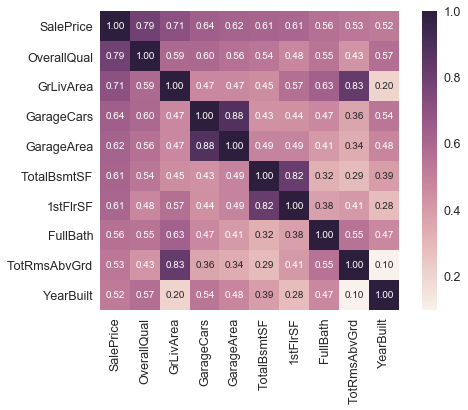

In [175]:
#saleprice correlation matrix
corrmat = data.corr()
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, label)[label].index
print(cols.values)
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

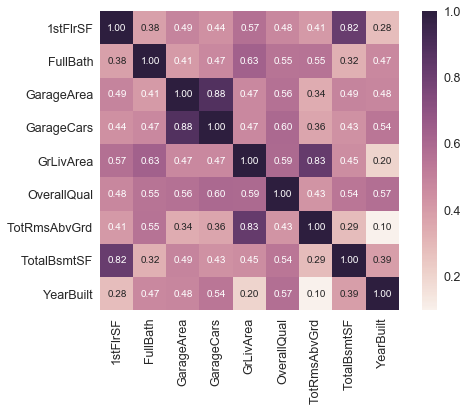

In [176]:
# Correlation matrix of cols except price
other_cols = np.setdiff1d(cols.values, label)
cm = np.corrcoef(data[other_cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=other_cols, xticklabels=other_cols)
plt.show()

# Feature engineering

In [177]:
data_fe = data.copy()

### OverallQual and other features

In [138]:
col1 = 'OverallQual'
col2 = 'GrLivArea'
new_col = col1 + '_' + col2
data_fe[new_col] = data_fe[col1] + data_fe[col2]
print(new_col," type:", data_fe[new_col].dtype)
correlation = data_fe[[label,new_col, col1, col2]].corr()[label]
correlation

OverallQual_GrLivArea  type: float64


SalePrice                1.000000
OverallQual_GrLivArea    0.838742
OverallQual              0.790982
GrLivArea                0.708624
Name: SalePrice, dtype: float64

In [139]:
col1 = 'OverallQual'
col2 = 'YearBuilt'
new_col = col1 + '_' + col2
data_fe[new_col] = data_fe[col1] + data_fe[col2]
correlation = data_fe[[label,new_col, col1, col2]].corr()[label]
correlation

SalePrice                1.000000
OverallQual_YearBuilt    0.739673
OverallQual              0.790982
YearBuilt                0.522897
Name: SalePrice, dtype: float64

In [140]:
col1 = 'OverallQual'
col2 = 'TotalBsmtSF'
new_col = col1 + '_' + col2
data_fe[new_col] = data_fe[col1] + data_fe[col2]
correlation = data_fe[[label,new_col, col1, col2]].corr()[label]
correlation

SalePrice                  1.000000
OverallQual_TotalBsmtSF    0.800189
OverallQual                0.790982
TotalBsmtSF                0.613581
Name: SalePrice, dtype: float64

In [146]:
col1 = 'OverallQual'
col2 = 'GarageArea'
new_col = col1 + '_' + col2
data_fe[new_col] = data_fe[col1] + data_fe[col2]
correlation = data_fe[[label,new_col, col1, col2]].corr()[label]
correlation

SalePrice                 1.000000
OverallQual_GarageArea    0.799699
OverallQual               0.790982
GarageArea                0.623431
Name: SalePrice, dtype: float64

In [147]:
col1 = 'OverallQual'
col2 = 'FullBath'
new_col = col1 + '_' + col2
data_fe[new_col] = data_fe[col1] + data_fe[col2]
correlation = data_fe[[label,new_col, col1, col2]].corr()[label]
correlation

SalePrice               1.000000
OverallQual_FullBath    0.766509
OverallQual             0.790982
FullBath                0.560664
Name: SalePrice, dtype: float64

In [148]:
col1 = 'OverallQual'
col2 = '1stFlrSF'
new_col = col1 + '_' + col2
data_fe[new_col] = data_fe[col1] + data_fe[col2]
correlation = data_fe[[label,new_col, col1, col2]].corr()[label]
correlation

SalePrice               1.000000
OverallQual_1stFlrSF    0.812689
OverallQual             0.790982
1stFlrSF                0.605852
Name: SalePrice, dtype: float64

In [149]:
col1 = 'OverallQual'
col2 = '2ndFlrSF'
new_col = col1 + '_' + col2
data_fe[new_col] = data_fe[col1] + data_fe[col2]
correlation = data_fe[[label,new_col, col1, col2]].corr()[label]
correlation

SalePrice               1.000000
OverallQual_2ndFlrSF    0.684243
OverallQual             0.790982
2ndFlrSF                0.319334
Name: SalePrice, dtype: float64

In [150]:
col1 = 'OverallQual'
col2 = 'LotFrontage'
new_col = col1 + '_' + col2
data_fe[new_col] = data_fe[col1] + data_fe[col2]
correlation = data_fe[[label,new_col, col1, col2]].corr()[label]
correlation

SalePrice                  1.000000
OverallQual_LotFrontage    0.708706
OverallQual                0.790982
LotFrontage                0.334820
Name: SalePrice, dtype: float64

In [153]:
col1 = 'OverallQual'
col2 = 'OverallCond'
new_col = col1 + '_' + col2
data_fe[new_col] = data_fe[col1] + data_fe[col2]
correlation = data_fe[[label,new_col, col1, col2]].corr()[label]
correlation

SalePrice                  1.000000
OverallQual_OverallCond    0.523013
OverallQual                0.790982
OverallCond               -0.077856
Name: SalePrice, dtype: float64

In [178]:
col1 = 'OverallQual'
col2 = 'FireplaceQu'
new_col = col1 + '_' + col2
data_fe[new_col] = data_fe[col1] * (data_fe[col2] + 1)
correlation = data_fe[[label,new_col, col1, col2]].corr()[label]
correlation

SalePrice                  1.000000
OverallQual_FireplaceQu    0.725836
OverallQual                0.790982
FireplaceQu                0.335953
Name: SalePrice, dtype: float64

In [179]:
col1 = 'OverallQual'
col2 = 'PoolArea'
new_col = col1 + '_' + col2
data_fe[new_col] = data_fe[col1] + data_fe[col2]
correlation = data_fe[[label,new_col, col1, col2]].corr()[label]
correlation

SalePrice               1.000000
OverallQual_PoolArea    0.570960
OverallQual             0.790982
PoolArea                0.092404
Name: SalePrice, dtype: float64

In [162]:
data_fe['Functional'].describe()

count     1460
unique       7
top          6
freq      1360
Name: Functional, dtype: int64

# Plot target

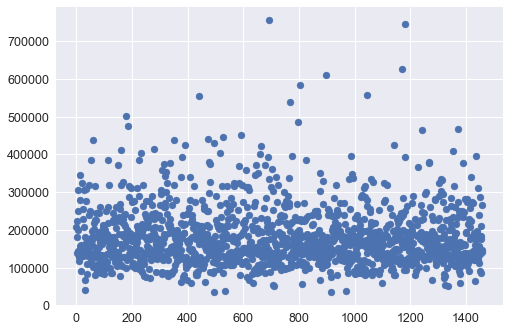

In [142]:
x = np.arange(len(target))
plt.scatter(x, target)
plt.show()

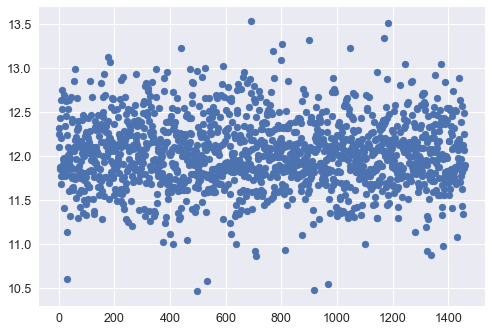

In [143]:
plt.scatter(x, np.log(target))
plt.show()